In [1]:
import numpy as np
from collections import defaultdict
import gym, math, sys
from collections import deque

In [2]:
class Agent:

    def __init__(self, nA=6):
        """ Initialize agent.

        Params
        ======
        - nA: number of actions available to the agent
        """
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.eps = 0.01
        self.cnt = 0

    def select_action(self, state):
        """ Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        probs = [self.eps/self.nA]*self.nA
        act = np.argmax(self.Q[state])
        probs[act] = 1- self.eps + self.eps/self.nA
        return np.random.choice(np.arange(self.nA), p=probs)

    def step(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        if not done:
            old_Q = self.Q[state][action]
            next_action =  np.argmax(self.Q[next_state])
            self.cnt += 1
            self.eps = 1.0/(self.cnt/100+1.0)
            #probs = [self.eps/self.nA]*self.nA
            #act = np.argmax(self.Q[state])
            #probs[act] = 1- self.eps + self.eps/self.nA
            #tQ = np.dot(np.array(self.Q[next_state]), np.array(probs))
            self.Q[state][action] = old_Q + 0.09*(reward + 0.8*self.Q[next_state][next_action] -old_Q)
            #self.Q[state][action] = old_Q + 0.01*(reward + 0.9*tQ -old_Q)
            #self.Q[state][action] += 1
        else:
            old_Q = self.Q[state][action]
            self.Q[state][action] = old_Q + 0.19*(reward -old_Q)

In [3]:
def interact(env, agent, num_episodes=20000, window=100):
    """ Monitor agent's performance.
    
    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state = env.reset()
        # initialize the sampled reward
        samp_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 100):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward

In [4]:
env = gym.make('Taxi-v2')
agent = Agent()
avg_rewards, best_avg_reward = interact(env, agent)

Episode 20000/20000 || Best average reward 9.296



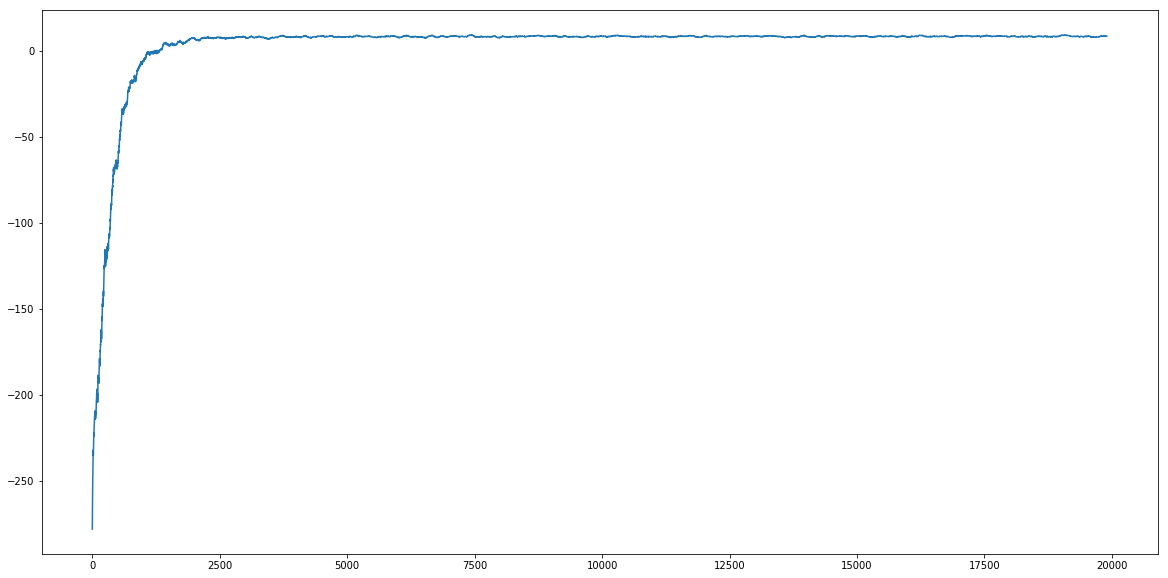

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.plot(avg_rewards)
plt.show()